In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixture4Modes as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture4Modes/../utils.py'>

In [2]:
d = 2
weights = np.ones(4)/4
ms = np.array([[0, 16], [0, 8], [-3, 12], [3, 12]])
Sigmas = np.array([[[1.2, 0], [0, 0.01]], [[1.2, 0], [0, 0.01]], [[0.01, 0], [0, 2]],[[0.01, 0], [0, 2]]])

In [3]:
true_mean = np.mean(ms, axis = 0)
true_variance = np.zeros((d, d))
for i in range(4):
    true_variance += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_variance = true_variance/4

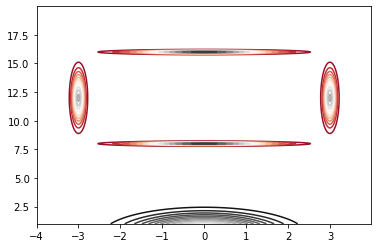

In [4]:
x, y = np.mgrid[-4:4:.01, 1:20:.01]
data = np.dstack((x, y))
z = 0
zinitial = multivariate_normal.pdf(data, np.array([0, 0]), np.eye(d))
for j in range(weights.size):
    z += weights[j]*multivariate_normal.pdf(data, ms[j,:], Sigmas[j,:,:])
plt.contour(x, y, z, 15, cmap='RdGy')
plt.contour(x, y, zinitial, 15, cmap = 'gray')

## Algorithms

In [5]:
Niter = 1000
gamma = 0.01
N = 300
h = gamma
X0 = np.random.multivariate_normal(np.array([0, 0]), np.eye(d), size = N)

In [6]:
component = np.random.randint(4, size = N*100)
true_sample = np.zeros((N, 2))
for n in range(N):
      true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)

In [7]:
Niter_ula = Niter*5
Niter_mala = Niter
Niter_fr = Niter*2
Niter_smcula = Niter*3
Niter_smcmala = Niter

In [8]:
Nalgo = 6
Nrep = 2

ula_chain = np.zeros((Nrep, Niter_ula, d, N))
mala_chain = np.zeros((Nrep, Niter_mala, d, N))
fr_x = np.zeros((Nrep, Niter_fr, d, N))
fr_w = np.zeros((Nrep, Niter_fr, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
smcula_x = np.zeros((Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Nrep, Niter_smcmala, N))

runtime = np.zeros((Nrep, Nalgo))

In [9]:
for i in range(Nrep):
    ### ULA
    start = time.time()
    ula_chain[i,:] = algo.ParallelULA(gamma, Niter_ula, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    mala_chain[i,:] = algo.ParallelMALA(gamma, Niter_mala, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 1] = end-start
    ### SMC-FR
    start = time.time()
    fr_x[i,:], fr_w[i,:] = algo.SMC_UnitFR(gamma, Niter_fr, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x[i,:], wfr_w[i,:] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    smcula_x[i,:], smcula_w[i,:] = algo.SMC_ULA(gamma, Niter_smcula, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    smcmala_x[i,:], smcmala_w[i,:] = algo.SMC_MALA(gamma, Niter_smcmala, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 5] = end-start

/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture4Modes/GaussianMixture4Modes.py:25: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sum(logpi, axis = 0))


In [10]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime

array([1.83876193, 1.5927242 , 1.96284342, 7.86675656, 1.77859545,
       1.86111283])

In [11]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [12]:
w1_ula = np.zeros((Nrep, d, Niter_ula))
w1_mala = np.zeros((Nrep, d, Niter_mala))
w1_fr = np.zeros((Nrep, d, Niter_fr))
w1_wfr = np.zeros((Nrep, d, Niter))
w1_smcula = np.zeros((Nrep, d, Niter_smcula))
w1_smcmala = np.zeros((Nrep, d, Niter_smcmala))

mmd_ula = np.zeros((Nrep, Niter_ula))
mmd_mala = np.zeros((Nrep, Niter_mala))
mmd_fr = np.zeros((Nrep, Niter_fr))
mmd_wfr = np.zeros((Nrep, Niter))
mmd_smcula = np.zeros((Nrep, Niter_smcula))
mmd_smcmala = np.zeros((Nrep, Niter_smcmala))

In [13]:
for j in range(Nrep):
    for i in range(Niter_ula):
        mmd_ula[j, i] = u.mmd_rbf(true_sample, ula_chain[j, i, :, :].T)
        for k in range(d):
            w1_ula[j, k, i]  = stats.wasserstein_distance(ula_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter_mala):
        mmd_mala[j, i] = u.mmd_rbf(true_sample, mala_chain[j, i, :, :].T)
        for k in range(d):
            w1_mala[j, k, i]  = stats.wasserstein_distance(mala_chain[j, i, k, :], true_sample[:, k])
    for i in range(Niter):
        mmd_wfr[j, i] = u.mmd_rbf(true_sample, wfr_x[j, i, :, :].T, w = wfr_w[j, i, :])
        for k in range(d):
            w1_wfr[j, k, i]  = stats.wasserstein_distance(wfr_x[j, i, k, :], true_sample[:, k], u_weights = wfr_w[j, i, :])
    for i in range(Niter_fr):
        mmd_fr[j, i] = u.mmd_rbf(true_sample, fr_x[j, i, :, :].T, w = fr_w[j, i, :])
        for k in range(d):
            w1_fr[j, k, i]  = stats.wasserstein_distance(fr_x[j, i, k, :], true_sample[:, k], u_weights = fr_w[j, i, :])
    for i in range(Niter_smcula):
        mmd_smcula[j, i] = u.mmd_rbf(true_sample, smcula_x[j, i, :, :].T, w = smcula_w[j, i, :])
        for k in range(d):
            w1_smcula[j, k, i]  = stats.wasserstein_distance(smcula_x[j, i, k, :], true_sample[:, k], u_weights = smcula_w[j, i, :])
    for i in range(Niter_smcmala):
        mmd_smcmala[j, i] = u.mmd_rbf(true_sample, smcmala_x[j, i, :, :].T, w = smcmala_w[j, i, :])
        for k in range(d):
            w1_smcmala[j, k, i]  = stats.wasserstein_distance(smcmala_x[j, i, k, :], true_sample[:, k], u_weights = smcmala_w[j, i, :])
    

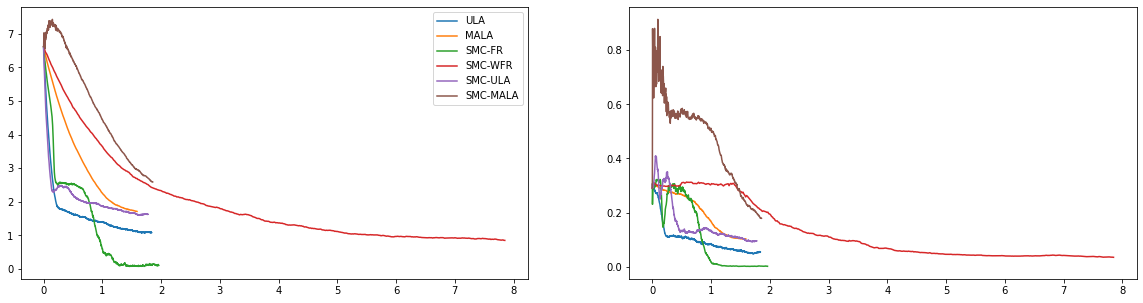

In [14]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(xx_ula, np.mean(np.mean(w1_ula, axis = 1), axis = 0), label = 'ULA')
plt.plot(xx_mala, np.mean(np.mean(w1_mala, axis = 1), axis = 0), label = 'MALA')
plt.plot(xx_fr, np.mean(np.mean(w1_fr, axis = 1), axis = 0), label = 'SMC-FR')
plt.plot(xx_wfr, np.mean(np.mean(w1_wfr, axis = 1), axis = 0), label = 'SMC-WFR')
plt.plot(xx_smcula, np.mean(np.mean(w1_smcula, axis = 1), axis = 0), label = 'SMC-ULA')
plt.plot(xx_smcmala, np.mean(np.mean(w1_smcmala, axis = 1), axis = 0), label = 'SMC-MALA')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(xx_ula, np.mean(mmd_ula, axis = 0))
plt.plot(xx_mala, np.mean(mmd_mala, axis = 0))
plt.plot(xx_fr, np.mean(mmd_fr, axis = 0))
plt.plot(xx_wfr, np.mean(mmd_wfr, axis = 0))
plt.plot(xx_smcula, np.mean(mmd_smcula, axis = 0))
plt.plot(xx_smcmala, np.mean(mmd_smcmala, axis = 0))